# Set up 


In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import sys
from scipy.optimize import LinearConstraint
import scipy.optimize as optimize
import threading
# from rpy2.robjects.packages import i|mportr, data
# from rpy2.robjects.lib.dplyr import DataFrame
from datetime import datetime
npand = np.logical_and
npor = np.logical_or
npnot = np.logical_not

In [2]:
path="./" + "sidedata/"
filename = path + "Alldata2.csv"

df=pd.read_csv(filename, index_col=None)
df['Probtype'] = np.where(df['Stimkind']==1, "CM",
                   np.where(df['Stimkind']==0, "AN",
                   np.where(df['Stimkind']==3, 'VM',"wrong")))

df['Oldnew'] = np.where(df['Old']==1, "old",
                   np.where(df['Old']==2, "new","wrong"))
df['Error'] = 1-df['Correctness']
df_org = df[df['RT']<2000]
df = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","Error","FileCondi"])[["RT"]].agg(["mean"])
# df[["Correctness","Error"]]
# df.groupby("Error")
df.index.name = 'Setsize'
df.reset_index(inplace=True)
# df["Error"]


df_err = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["Error"]].agg(["mean"]).reset_index()
df_crt = df_org[df_org["Error"]==0].\
groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["RT"]].agg(["mean"]).reset_index()

df_err.columns = df_err.columns.droplevel(1)
df_crt.columns = df_crt.columns.droplevel(1)

# df_err.reindex(np.arange(1,df_err.shape[0]))
# df_crt.reindex(np.arange(1,df_crt.shape[0]))

# Parameter set

In [3]:
global boost, alpha, beta, s, c ,Old_crit ,New_crit ,\
    t0 ,kao , F, L
  
alpha={}; beta ={}; s = {}; F = {}; L = {}; t0 = {}


boost = 1.05
alpha["all"] = 0.19
# alpha['CM'] = 0.1969 
# alpha['VM'] = 0.1969 
alpha["ANnew"]=0.84

beta["all"] =1.2
# beta['CM'] = 1.228
# beta['VM'] = 1.228
beta["ANnew"]= 1.708

s["all"]=0.01
# s["ANnew"] = 0.01
# s["CM"] = 0.02
# s["VM"] = 0.02
c = 0.3938

Old_crit = 1.9197
New_crit = -2.33
t0["all"] = 699.98
t0["ann"] = 699.98

kao = 37

#---CM
F["CM_oldiold_oldinew"] = 0.2

L["CM_oldiold_newinew"] = 0.2
L["CM_oldinew_newiold"] = 0.2

#---AN
F["AN_oldiold_oldinew"] = 0.2

# Assign LTM global

In [4]:
def assign_LTM_global(item_condi, walk, item):
    
    global F,L,Fnow,Lnow
    
    if item_condi=="CM":
        
        if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":
            
            Fnow = F["CM_oldiold_oldinew"]
        else: Fnow = 0
        
        if walk+"i"+item == "oldiold" or walk+"i"+item == "newinew":
            
            Lnow = L["CM_oldiold_newinew"]
        elif walk+"i"+item == "oldinew" or walk+"i"+item == "newiold":
            
            Lnow = L["CM_oldinew_newiold"]
        else: Lnow=0
            
    if item_condi == "AN":
        
        if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":
            
            Fnow = F["AN_oldiold_oldinew"]
        else: Fnow=0
        
        Lnow = 0
    
    return(Fnow + Lnow)

assign_LTM_global("AN","old","old")
        

0.2

# Calc A (activation)

In [5]:
# seperate albes
def calcA(df, name):

    
    dnow = df[df['FileCondi']==name]
    a = np.zeros((dnow.shape[0], 8))  #activation
    
    snow=s["all"]
    betanow=beta["all"] 
    alphanow=alpha["all"]
    
    m_ANnew = np.repeat(9999.0,8)
    m_all = np.repeat(9999.0,8)
    
#     tfcondi = np.zeros((8,dnow.shape[0]))
    tfcondi1 = np.array([npand.reduce((dnow["Lag"]!=j,dnow["Probtype"]=="AN",dnow["Oldnew"]=="new")) for j in range(1,9)])
    tfcondi0 = np.array([npand.reduce((dnow["Lag"]!=j,npnot(npand(dnow["Probtype"]=="AN",dnow["Oldnew"]=="new")))) for j in range(1,9)])
    tfcondi11 = np.array([npand.reduce((dnow["Lag"]==j,dnow["Probtype"]=="AN",dnow["Oldnew"]=="new")) for j in range(1,9)])
    tfcondi00 = np.array([npand.reduce((dnow["Lag"]==j,npnot(npand(dnow["Probtype"]=="AN",dnow["Oldnew"]=="new")))) for j in range(1,9)])
    
    for j in range(1,9):
        
        indexj = j-1
        
        m_all[indexj] = j**(-beta["all"]) + alpha["all"]
        m_ANnew[indexj] = j**(-beta["ANnew"]) + alpha["ANnew"]
        
        a[tfcondi1[indexj,:],indexj] = m_ANnew[indexj] * s["all"]
        a[tfcondi0[indexj,:],indexj] = m_all[indexj] * s["all"]
        a[tfcondi11[indexj,:],indexj] = m_ANnew[indexj]
        a[tfcondi00[indexj,:],indexj] = m_all[indexj]
        

    for i in range(a.shape[0]): a[i,dnow['Setsize'].iloc[i]:] = 0 #a_ij suit for the correct amount of setsize

#     print(npor.reduce((tfcondi0,tfcondi00,tfcondi1,tfcondi11)))
    debug = 0
    if debug==1:
        for i in range(a.shape[0]):
            print(i, "begin\n","a is",a[i].round(5),\
                  "\n m_all is", np.array(m_all).round(3),
                  "\n m_ANnew is", np.array(m_all).round(3),
                  "\n Lag is ",dnow['Lag'].iloc[i],\
#                   "\n Setsize is", dnow["Setsize"].iloc[i],\
                  "\n Probtype:",\
                  dnow["Probtype"].iloc[i],\
                  "\n Oldnew: ",dnow["Oldnew"].iloc[i],\
                  "\n True_nolag,ANnew?", tfcondi1[:,i],\
                  "\n True_nolag,CMnew?", tfcondi1[:,i],\
#                   "\n Ai is", a[i,:].sum().round(2),\
#                   "\n snow", snow,\
                 "\n------------------------------------------------" )

    
    A = a.sum(axis = 1)
    
    return(A)

# print(calcA(df[df["Error"]==0], "CMat"))

name="MIX"
A0=calcA(df,name)
df_sub= df[df['FileCondi']==name]
show =[df_sub["FileCondi"].iloc[i]+\
        "-- "+A0[i].round(5).astype(str)+\
      "--"+ df_sub["Setsize"].iloc[i].astype(str)+\
      "--"+df_sub["Probtype"].iloc[i]+\
      "--"+df_sub["Oldnew"].iloc[i] for i in range(A0.size)]
print(np.sort(show))

['MIX-- 0.01815--2--CM--new' 'MIX-- 0.01815--2--CM--new'
 'MIX-- 0.02652--4--CM--new' 'MIX-- 0.02652--4--CM--new'
 'MIX-- 0.02986--2--AN--new' 'MIX-- 0.02986--2--AN--new'
 'MIX-- 0.03853--8--CM--new' 'MIX-- 0.03853--8--CM--new'
 'MIX-- 0.04913--4--AN--new' 'MIX-- 0.04913--4--AN--new'
 'MIX-- 0.08448--8--AN--new' 'MIX-- 0.08448--8--AN--new'
 'MIX-- 0.30827--8--AN--old' 'MIX-- 0.30827--8--AN--old'
 'MIX-- 0.30827--8--CM--old' 'MIX-- 0.30827--8--CM--old'
 'MIX-- 0.32246--8--AN--old' 'MIX-- 0.32246--8--AN--old'
 'MIX-- 0.32246--8--CM--old' 'MIX-- 0.32246--8--CM--old'
 'MIX-- 0.34194--8--AN--old' 'MIX-- 0.34194--8--AN--old'
 'MIX-- 0.34194--8--CM--old' 'MIX-- 0.34194--8--CM--old'
 'MIX-- 0.37014--8--AN--old' 'MIX-- 0.37014--8--AN--old'
 'MIX-- 0.37014--8--CM--old' 'MIX-- 0.37014--8--CM--old'
 'MIX-- 0.40219--4--AN--old' 'MIX-- 0.40219--4--AN--old'
 'MIX-- 0.40219--4--CM--old' 'MIX-- 0.40219--4--CM--old'
 'MIX-- 0.4142--8--AN--old' 'MIX-- 0.4142--8--AN--old'
 'MIX-- 0.4142--8--CM--old' 'MIX-

# Calc p (drift rate)

In [6]:

def calcp(df, name):
    
    dnow = df[df['FileCondi']==name]
    
    A = calcA(dnow, name)
    p = np.repeat(3.0, A.shape[0])
    
    probs = dnow["Probtype"].astype("category").cat.categories.to_numpy() #get categories name
    

    for iprob in probs:
        
        for ion in ["old","new"]:
            
            tf_ion = dnow['Oldnew'] == ion
            tf_iprob = dnow['Probtype'] == iprob
            tf_all = np.logical_and(tf_ion, tf_iprob)
            
            IR_old_current = assign_LTM_global(iprob,"old",ion)
            IR_new_current = assign_LTM_global(iprob,"new",ion)
    
            p[tf_all] = (A[tf_all] + IR_old_current)/(A[tf_all] + IR_old_current + c + IR_new_current)
        
#             print(iprob,ion,IR_old_current,IR_new_current)
#             print("**","MIX",iprob,"oldi"+ion+"--",IR_old_current,
#                                       "newi"+ion+"--",IR_new_current, p[tf_all])
    return(np.array(p))




# name="MIX"
# df_sub = df_err[df_err['FileCondi']==name]
# df_sub=df_sub.reset_index()
# # name="MIX"
# # df_sub = df[df['FileCondi']==name]
# p0=calcp(df_sub,name)
# show =[df_sub["FileCondi"].iloc[i]+\
#        "--"+df_sub["Probtype"].iloc[i]+\
#        "--"+ df_sub["Setsize"].iloc[i].astype(str)+\
#        "--"+df_sub["Oldnew"].iloc[i]+\
#        "-- "+p0[i].round(5).astype(str) for i in range(p0.size)]
# print(np.sort(show))



name="MIX"
df_sub = df_crt[df_crt['FileCondi']==name]
df_sub=df_sub.reset_index()
calcp(df_sub,name)

array([0.36856706, 0.41321371, 0.38749076, 0.41802754, 0.41941788,
       0.42479644, 0.78000648, 0.68009106, 0.72886498, 0.63592336,
       0.78103041, 0.6822517 , 0.63310374, 0.60461575, 0.72989732,
       0.63778232, 0.59696684, 0.57463974, 0.78248264, 0.68530056,
       0.63716269, 0.60932544, 0.59146689, 0.5791551 , 0.57021108,
       0.5634508 , 0.73136451, 0.64041601, 0.60022484, 0.57826708,
       0.56464251, 0.5554513 , 0.5488746 , 0.54395859])

In [7]:
print(F["CM_oldiold_oldinew"], L["CM_oldiold_newinew"],
          L["CM_oldinew_newiold"], F["AN_oldiold_oldinew"])
print(alpha)

0.2 0.2 0.2 0.2
{'all': 0.19, 'ANnew': 0.84}


# RW 

In [8]:

def calc_theoretical_RW(df, name, which):
    
    A = calcA(df,name)
    p = calcp(df,name)
    q = 1-p
    
    dnow = df[df['FileCondi']==name]
    
    p_resp_old = np.zeros(p.size)
    pred_correct = np.zeros(p.size)
    pred_rt = np.zeros(p.size)

    theta1 = np.zeros(p.size)
    theta2 = np.zeros(q.size)
    theta11 = np.zeros(p.size)
    theta22 = np.zeros(q.size)
    exp_nstep = np.zeros(p.shape[0])
    
    filecondis = df["FileCondi"].astype("category").cat.categories.to_numpy() #get all finle names
    
    AA = Old_crit
    BB = -New_crit # bb is a postive number
    
    exp_nstep = np.zeros(p.shape[0])
    if which=="crt":

        theta1 = ((p/q)**(AA+BB)+1)/((p/q)**(AA+BB)-1)
        theta2 = ((p/q)**BB+1)/((p/q)**BB-1)


        tf = np.logical_and(p!=q , dnow["Oldnew"]=='old')
        exp_nstep[tf] = (1/(p[tf]-q[tf]))*(theta1[tf]*(AA+BB) - theta2[tf]*BB)

        tf = np.logical_and(p==q , dnow["Oldnew"]=='old')
        exp_nstep[tf] = (AA/3)*(2*BB+AA)

        theta1 = ((p/q)**(-(AA+BB))+1)/((p/q)**(-(AA+BB))-1)
        theta2 = ((p/q)**-AA+1)/((p/q)**-AA-1)

        tf = np.logical_and(p!=q , dnow["Oldnew"]=='new')
        exp_nstep[tf] = (1/(q[tf]-p[tf]))*(theta1[tf]*(AA+BB) - theta2[tf]*AA)
        tf = np.logical_and(p==q , dnow["Oldnew"]=='new')
        exp_nstep[tf] = (BB/3)*(2*AA+BB)
        
        suprise = np.logical_and.reduce((np.logical_or(dnow["FileCondi"]=="MIX",dnow["FileCondi"]=="MIX2"),
                                         dnow["Probtype"]=="AN",dnow["Oldnew"]=="new"))
        notsuprise = np.logical_not(suprise)

        pred_rt[suprise] = t0["ann"] + kao * exp_nstep[suprise]
        pred_rt[notsuprise] = t0["all"] + kao * exp_nstep[notsuprise]


    #------------------- correct response
    elif which == "err":

        p_resp_old[p!=q] = ((1-(q/p)**BB)/(1-(q/p)**(AA+BB)))[p!=q]
        p_resp_old[p==q] = BB/(AA+BB)

        pred_correct[dnow["Oldnew"]=='old'] = p_resp_old[dnow["Oldnew"]=="old"]
        pred_correct[dnow["Oldnew"]=="new"] = 1-p_resp_old[dnow["Oldnew"]=="new"]

    

    
    if which == "crt": 
        return(np.array(pred_rt))
    elif which == "err":
        return(np.array(pred_correct))
          





name="MIX"
df_sub = df_err[df_err['FileCondi']==name]
df_sub=df_sub.reset_index()
rw=calc_theoretical_RW(df_sub,name,"err")
show =[df_sub["FileCondi"].iloc[i]+\
       "--"+df_sub["Probtype"].iloc[i]+\
       "--"+ df_sub["Setsize"].iloc[i].astype(str)+\
       "--"+df_sub["Oldnew"].iloc[i]+\
       "-- "+rw[i].round(5).astype(str) for i in range(rw.size)]
print(np.sort(show))

['MIX--AN--2--new-- 0.717' 'MIX--AN--2--old-- 0.86246'
 'MIX--AN--2--old-- 0.952' 'MIX--AN--4--new-- 0.68227'
 'MIX--AN--4--old-- 0.75197' 'MIX--AN--4--old-- 0.79804'
 'MIX--AN--4--old-- 0.86507' 'MIX--AN--4--old-- 0.95262'
 'MIX--AN--8--new-- 0.62001' 'MIX--AN--8--old-- 0.67713'
 'MIX--AN--8--old-- 0.69002' 'MIX--AN--8--old-- 0.70672'
 'MIX--AN--8--old-- 0.72905' 'MIX--AN--8--old-- 0.75993'
 'MIX--AN--8--old-- 0.80418' 'MIX--AN--8--old-- 0.86869'
 'MIX--AN--8--old-- 0.95349' 'MIX--CM--2--new-- 0.63242'
 'MIX--CM--2--old-- 0.80232' 'MIX--CM--2--old-- 0.91382'
 'MIX--CM--4--new-- 0.62281' 'MIX--CM--4--old-- 0.69834'
 'MIX--CM--4--old-- 0.73876' 'MIX--CM--4--old-- 0.80511'
 'MIX--CM--4--old-- 0.91474' 'MIX--CM--8--new-- 0.60915'
 'MIX--CM--8--old-- 0.63889' 'MIX--CM--8--old-- 0.64868'
 'MIX--CM--8--old-- 0.66162' 'MIX--CM--8--old-- 0.67942'
 'MIX--CM--8--old-- 0.70508' 'MIX--CM--8--old-- 0.74442'
 'MIX--CM--8--old-- 0.80903' 'MIX--CM--8--old-- 0.91604']


In [9]:
df_err[df_err['FileCondi']==name]

,Oldnew,Setsize,Probtype,Lag,FileCondi,Error
2,new,2,AN,0,MIX,0.026667
6,new,2,CM,0,MIX,0.039583
11,new,4,AN,0,MIX,0.037344
15,new,4,CM,0,MIX,0.116034
20,new,8,AN,0,MIX,0.052632
24,new,8,CM,0,MIX,0.190776
29,old,2,AN,1,MIX,0.039841
33,old,2,AN,2,MIX,0.048193
37,old,2,CM,1,MIX,0.056225
41,old,2,CM,2,MIX,0.041667


# Calculate WSSE

In [10]:
df_sub_err = df_err[df_err["FileCondi"] == name]
df_sub_err = df_sub_err.reset_index()
calc_theoretical_RW(df_sub_err, name, "err")

array([0.71700344, 0.63242252, 0.68226834, 0.62280556, 0.62001307,
       0.60915061, 0.95200434, 0.86246127, 0.91381874, 0.80231699,
       0.95262148, 0.86506764, 0.7980373 , 0.7519665 , 0.91474117,
       0.80511019, 0.73875624, 0.69833839, 0.95348755, 0.86869228,
       0.80418166, 0.75992895, 0.72905026, 0.70672424, 0.69001569,
       0.67713228, 0.91604085, 0.80902865, 0.74442463, 0.70508315,
       0.67941861, 0.66162386, 0.64867526, 0.63888792])

In [11]:
w={}
w["new_rt"] = 4*2
w["old_rt"] = 1*2
w["new_err"] = 4
w["old_err"] = 1


def calc_wssd(df, name):

    df_sub_org = df[df["FileCondi"] == name]
    df_sub_err = df_err[df_err["FileCondi"] == name]
    df_sub_crt = df_crt[df_crt["FileCondi"] == name]

    df_sub_err = df_sub_err.reset_index()
    df_sub_crt = df_sub_crt.reset_index()

    pred_correct = calc_theoretical_RW(df_sub_err, name, "err")
    pred_crt= calc_theoretical_RW(df_sub_crt, name,"crt")


    df_sub_crt["pred_crt"] = pred_crt/1000 #translate crt to seconds. 
    df_sub_err["pred_error"] = 1- pred_correct

    df_sub_crt["RT"]= df_sub_crt["RT"]/1000

    df_sub_crt["SSD_RT"] = ((df_sub_crt["RT"] - df_sub_crt["pred_crt"])**2).to_numpy()
    df_sub_err["SSD_err"] = ((df_sub_err["Error"] - df_sub_err["pred_error"])**2).to_numpy()

    df_sub_crt["wSSD_RT"] = [df_sub_crt.loc[i,"SSD_RT"] *\
                             w[df_sub_crt.loc[i,"Oldnew"]+"_rt"] for i in range(df_sub_crt.shape[0])]

    df_sub_err["wSSD_err"] = [df_sub_err.loc[i,"SSD_err"] *\
                             w[df_sub_err.loc[i,"Oldnew"] + "_err"] for i in range(df_sub_err.shape[0])]
    
    adj_oldnew=0
    if adj_oldnew==1:
        print("\nERR","old",df_sub_err[df_sub_err["Oldnew"]=="old"]["wSSD_err"].sum(),\
             "new",df_sub_err[df_sub_err["Oldnew"]=="new"]["wSSD_err"].sum(),
             "\nRT","old",df_sub_crt[df_sub_crt["Oldnew"]=="old"]["wSSD_RT"].sum(),\
             "new",df_sub_crt[df_sub_crt["Oldnew"]=="new"]["wSSD_RT"].sum(),)

    WSSD = df_sub_err["wSSD_err"].sum() + df_sub_crt["wSSD_RT"].sum()

    return(WSSD)

# time1=time.time()
calc_wssd(df_org, "MIX2")
# print(time.time()-time1)
# df_sub_agg, WSSD = calc_wssd(df, "MIX")



3.122157434276116

In [12]:
fitsel.iloc[:,1:fitsel.shape[1]-1]

NameError: name 'fitsel' is not defined

In [13]:
fitsel = pd.read_csv("2019-12-04T05:16:46_single_test_MIX1_alphabeta-ANnew.csv")
fitsel
[alpha["all"],alpha["ANnew"],beta["all"],beta["ANnew"],s["all"],
         c, Old_crit, New_crit, t0["all"],
          t0["ann"], kao, F["CM_oldiold_oldinew"], L["CM_oldiold_newinew"],
          L["CM_oldinew_newiold"], F["AN_oldiold_oldinew"]]=fitsel.iloc[1,1:fitsel.shape[1]-2].astype(float).to_list()

name="MIX"
df_sub = df_crt[df_crt['FileCondi']==name]
df_sub=df_sub.reset_index()
rw=calc_theoretical_RW(df_sub,name,"crt")
rw
# calc_wssd(df_err,df_crt, "MIX")
calcp(df_sub, "MIX")
# calcA(df_sub,"MIX")

array([0.24804542, 0.30027726, 0.26521228, 0.33738114, 0.29691385,
       0.3871527 , 0.72423863, 0.67000528, 0.7154035 , 0.6649441 ,
       0.73124588, 0.67998985, 0.64943752, 0.62784388, 0.72204449,
       0.67411085, 0.64623213, 0.62683093, 0.74131342, 0.69416243,
       0.66637387, 0.64687432, 0.63198603, 0.62002685, 0.610087  ,
       0.60161947, 0.73163549, 0.68721704, 0.66162367, 0.64391619,
       0.63053336, 0.61986832, 0.61106099, 0.60359862])

In [14]:
fitsel

,Unnamed: 0,alpha,alpha_an,beta,beta_an,s_all,c,old_crt,new_crt,t0,t0ann,kappa,F_cmoonn,L_cmoonn,Lcmonno,an_oool,wssd,w
0,0,0.19860734002558392,0.04696126617339491,0.6969067713957103,1.3531353857930815,0.031503879126670166,0.3362888688262133,2.608703286099833,-2.775202196261749,285.87713817771817,322.8454799040075,100.0,0.039059346202574244,0.12192248614675698,0.06081515092009005,0.029059346202574256,6.788627,new_rt:8
1,1,0.01000000000000001,0.19022510629596395,0.4447868031550001,5.001584828912271,0.03463309833609828,0.4297493971064683,3.2664255760698913,-3.775202127509491,375.215090291528,387.1500541527027,50.62148547239369,0.10287002235243999,0.07799421438493287,0.05425134360431973,0.09287002235243999,2.059571,old_rt:2
2,2,0.18762876441157114,0.04934191538664374,0.6740053960880652,1.376565651025962,0.033156512747271175,0.3519691399997976,2.715251107889301,-2.886021952396167,294.21085441101684,333.3115810057633,91.34028830175836,0.04475110850204903,0.1374786268459826,0.07096240305058504,0.03475110850204903,6.019361,new_err:4
3,3,0.1313791089998338,0.13700016135573018,2.168415546302744,8.448398282951084,0.06433813286974341,0.2430812996904491,5.336809730450128,-8.0,694.8824395671984,683.1618813405466,5.0,0.00999999999999893,0.09704052657651413,0.08704052657651314,8.345282079277064e-17,14.349496,old_err:1
4,4,0.22173649458907851,0.20455139639120454,0.6735266925424036,10.0,0.03170598115566514,0.4156211125121316,2.9122521870180336,-3.1999933207530886,337.48532544553757,362.9164108980115,71.47902029886275,0.08002433283272994,0.09015186672982202,0.05316334986549117,0.07002433283272995,3.748147,--------------
5,5,0.1388848714357685,0.10912107793031982,2.1166837936732694,2.5060396279338852,0.06387477459716166,0.2541710728240551,5.1679886288176835,-8.0,696.0602794113232,680.7620863883052,5.101447190761437,0.010029353754540228,0.10148004975168767,0.09148004975168783,0.0,14.015656,--------------
6,6,0.07503715245058926,0.016942361724409362,0.5152015218711549,1.1342767601178794,0.04014081895518375,0.46718242307376706,3.5271941940515186,-3.9667698600552583,384.0439211814622,407.7363573118396,43.8805915714573,0.10932799298342398,0.15013268714975467,0.09999547324075507,0.09932799298342397,1.306099,--------------
7,7,0.23023765452638092,0.19048873851217715,0.7130236819167951,5.512645518297232,0.02819904153369659,0.35101828188051065,2.5688783933900794,-2.782183894460984,292.9238265782032,323.18142356294675,100.0,0.05081968785416421,0.07698525109375527,0.03994407907543239,0.04081968785416421,6.624461,--------------
8,8,0.1313780613173631,0.13677601903797035,2.1885482545033184,10.0,0.06389518911040556,0.2412346451808618,5.330361382914805,-8.0,694.9525137372275,683.3609824509483,5.000000000000725,0.010000000000038716,0.09722533260603695,0.08722533260609601,1.9734895234312345e-14,14.425261,--------------
9,9,0.22168889883883922,0.053121057060462676,0.6850401486351863,1.1811645077528878,0.033838991221174425,0.43136498334102397,3.0246356814510755,-3.35882047603362,357.8133201970724,373.85355024166546,63.274443549486996,0.0837865181897058,0.10270616495153548,0.062142331838116446,0.07378651818970579,2.856954,--------------


# Parameter search

## optim_wsse

In [15]:
def optim_wsse(params_dic):
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
        t0 ,kao ,F, L,t

    alpha={}; beta ={}; s = {}; F = {}; L={};t={}
    
    # print(params)  # <-- you'll see that params is a NumPy array
    [
        alpha["all"],
        alpha["ANnew"],
        beta["all"],
        beta["ANnew"],

        s["all"],

        c,

        Old_crit,
        New_crit,

        t0["all"],
        t0["ann"],
        
        kao,

        #---CM
        F["CM_oldiold_oldinew"],

        L["CM_oldiold_newinew"],
        L["CM_oldinew_newiold"],

        #---AN
        F["AN_oldiold_oldinew"]] = params_dic
    


    return calc_wssd(df_org, "MIX2")


## random start

In [16]:
def random_start():
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
    t0 ,kao , F, L,t
  
    alpha={}; beta ={}; s = {}; F = {}; L = {};t={}

    alpha["all"] = np.random.uniform(0.1,1)
    alpha["ANnew"] = np.random.uniform(0.1,1)
    
    beta["all"] = np.random.uniform(1,2)
    beta["ANnew"] = np.random.uniform(1,2)
    
    s["all"] = np.random.uniform(0.01,1)

    c = np.random.uniform(0.05,0.99)

    Old_crit = np.random.uniform(1,5)
    New_crit = np.random.uniform(-5,-1)
    t0["all"] = 699
    t0["ann"]=699
    kao = 37

    #---CM
    F["CM_oldiold_oldinew"] = np.random.uniform(0.01,1)

    L["CM_oldiold_newinew"] = np.random.uniform(0.01,1)
    L["CM_oldinew_newiold"] = np.random.uniform(0.001,1)

    #---AN
    F["AN_oldiold_oldinew"] = np.random.uniform(0.001,1)
    
    param_dic=[
        alpha["all"],
        alpha["ANnew"],
        beta["all"],
        beta["ANnew"],
        s["all"],
        c,
        Old_crit,
        New_crit,
        t0["all"],
        t0["ann"],
        kao,
        F["CM_oldiold_oldinew"],
        L["CM_oldiold_newinew"],
        L["CM_oldinew_newiold"],
        F["AN_oldiold_oldinew"]]
    return(param_dic)



## bdd and Jcobian

In [17]:
bdd = (

(0.01, 1.0), #alphaall
(0.01, 1.0), #alphaall
(0.01, 10.0), #beta_all
(0.01, 10.0), #beta_all
(0.01, 1.0), #s all

(0.01, 2), #c

(1, 8.0), #old_cr
(-8.0, -1), #new_cr
(100, 800), #t0_all
(100, 800), #t0_ann
(5, 100), #kao

(0,2),#F["CM_oldiold_oldinew"],

(0,2),#L["CM_oldiold_newinew"],
(0,2),#L["CM_oldinew_newiold"],

#---AN
(0,2)#F["AN_oldiold_oldinew"]
  )

def Jcstrain():
    linear_constraint = LinearConstraint(\
       [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1,  0],
        [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,  0, -1]],\
        [0.01, 0.01],[np.inf,np.inf])

    return(linear_constraint)

## Actual search

In [18]:
    
def actual_search():# 

    
    numit=15
    global fitted_params3,result
    fitted_params3 = np.zeros((numit,np.array(bdd).shape[0]))
    for i in range(0,numit):
        time1 = time.time()
        param_dic = random_start()
#         result = optimize.minimize(optim_wsse, param_dic,\
#                                bounds=bdd,options={'verbose': 1,"maxiter" : 800},
#                                    constraints=[Jcstrain(), ],
#                                    method='trust-constr')
        result = optimize.minimize(optim_wsse, param_dic,\
                       bounds=bdd,options={"maxiter" : 800},
                           constraints=[Jcstrain(), ])
        print(i)
        print("time:", time.time()-time1)
        if result.success:
            fitted_params3[i,:] = result.x
        else: 
            print(result.message)


    time2 = time.time()
    print(time2-time1)

## Write in file

In [20]:
# actual_search()

def write_file(which_work):
    
    Parnames = ["alpha","alpha_an","beta","beta_an","s_all",
                "c","old_crt","new_crt","t0","t0ann","kappa","F_cmoonn","L_cmoonn","Lcmonno","an_oool"]

    fitted_params3
    fitpdf=pd.DataFrame(fitted_params3)
    fitpdf.columns=Parnames
    now = datetime.now()
    current_time = now.strftime("%Y-%m-%dT%H:%M:%S")#now.strftime("%m_%d_%H_%M")
#     print("Current Time =", current_time)
    fitsel=fitpdf[fitpdf["alpha"]>0]
    #------
#     print(bdd)
    bddstr=np.array(bdd).astype(str)
    bddbdd=pd.DataFrame([[bddstr[i,0]+" ~ "+bddstr[i,1] for i in range(bddstr.shape[0])]])
    bddbdd.columns=Parnames
    fitsel=fitsel.append(bddbdd, sort=False)
    # print(fitsel)
    
    
    #======= write wssd
    wssd_all = np.zeros(fitsel.shape[0])
    for i in range(fitsel.shape[0]-1):
        [alpha["all"],alpha["ANnew"],beta["all"],beta["ANnew"],s["all"],
         c, Old_crit, New_crit, t0["all"],
          t0["ann"], kao, F["CM_oldiold_oldinew"], L["CM_oldiold_newinew"],
          L["CM_oldinew_newiold"], F["AN_oldiold_oldinew"]]=fitsel.iloc[i,:].astype(float).to_list()
        wssd_all[i]=calc_wssd(df_org,"MIX2")
    fitsel["wssd"]=wssd_all
    filen = current_time + "_" + which_work + ".csv"
    #=======
    #=====
    w_curr=np.repeat("--------------",fitsel.shape[0])
    w_keys = [i for i in w.keys()]
    w_values=[i for i in w.values()]
    for i in range(len(w_keys)):
        w_curr[i]= w_keys[i]+":"+str(w_values[i])

    fitsel["w"]=w_curr
    #===============
    
    filen = current_time + "_" + which_work + ".csv"
    fitsel.to_csv(filen)
    print(filen)

    return(fitsel)
    

current = "single_test_MIX2_alphabeta-ANnew"

fitsel=write_file(current)
fitsel

2019-12-12T03:51:52_single_test_MIX2_alphabeta-ANnew.csv


,alpha,alpha_an,beta,beta_an,s_all,c,old_crt,new_crt,t0,t0ann,kappa,F_cmoonn,L_cmoonn,Lcmonno,an_oool,wssd,w
0,0.219309,0.127994,2.338,6.10264,0.0498411,0.312984,4.78509,-4.61435,686.469,701.59,15.457,0.0873243,0.01,0,0.0773243,18.548884,new_rt:8
1,0.222176,0.130704,2.32023,8.26074,0.049869,0.32037,4.83532,-4.65178,686.225,701.654,15.188,0.0920728,0.01,0,0.0820728,18.405408,old_rt:2
2,0.222259,0.131344,2.32022,9.27627,0.0498892,0.321768,4.85715,-4.66948,686.591,701.516,15.0487,0.0933437,0.01,0,0.0833437,18.378044,new_err:4
3,0.201821,0.0742144,2.40946,2.22508,0.0509817,0.272894,4.68091,-4.41887,685.901,702.52,16.5056,0.0605033,0.0154287,0.00542865,0.0505033,19.284582,old_err:1
4,0.204395,0.0686178,2.38809,2.0988,0.051282,0.275665,4.58762,-4.4234,685.846,702.725,16.8311,0.0583907,0.0154656,0.00546564,0.0483907,19.241096,--------------
0,0.01 ~ 1.0,0.01 ~ 1.0,0.01 ~ 10.0,0.01 ~ 10.0,0.01 ~ 1.0,0.01 ~ 2.0,1.0 ~ 8.0,-8.0 ~ -1.0,100.0 ~ 800.0,100.0 ~ 800.0,5.0 ~ 100.0,0.0 ~ 2.0,0.0 ~ 2.0,0.0 ~ 2.0,0.0 ~ 2.0,0.000000,--------------


# Final Random Walk

In [136]:
s_AN=0.01
s_others = 0.07
def finalRW(df_org):
    names = df_org["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    df_all_crt= pd.DataFrame()
    df_all_err= pd.DataFrame()

    df_sub_err = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["Error"]].agg(["mean"]).reset_index()
    df_sub_crt = df_org[df_org["Error"]==0].\
    groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["RT"]].agg(["mean"]).reset_index()

    for iname in names:

        pred_correct = calc_theoretical_RW(df_sub_err, iname,"err")
        pred_crt= calc_theoretical_RW(df_sub_crt, iname,"crt")
        
        
        df_temp_crt = df_sub_crt[df_sub_crt["FileCondi"] == iname]
        df_temp_err = df_sub_err[df_sub_err["FileCondi"] == iname]
        
        df_temp_crt.columns = df_temp_crt.columns.droplevel(1)
        df_temp_err.columns = df_temp_err.columns.droplevel(1)
        
        df_temp_crt["pred_rt"] = pred_crt   
        df_temp_err["pred_error"] = 1- pred_correct

        df_all_crt = df_all_crt.append(df_temp_crt)
        df_all_err = df_all_err.append(df_temp_err)


    return(df_all_crt, df_all_err)

finalRW(df_org)

C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(    Oldnew  Setsize Probtype  Lag FileCondi          RT     pred_rt
 0      new        2       AN    0    ANpure  816.343927  721.837161
 9      new        4       AN    0    ANpure  837.035915  754.703679
 18     new        8       AN    0    ANpure  848.955107  818.331300
 27     old        2       AN    1    ANpure  715.675351  719.644316
 31     old        2       AN    2    ANpure  768.006263  806.022810
 ..     ...      ...      ...  ...       ...         ...         ...
 148    old        8       VM    4    VMpure  912.040000  926.204669
 149    old        8       VM    5    VMpure  925.304762  930.262775
 150    old        8       VM    6    VMpure  988.977528  929.710192
 151    old        8       VM    7    VMpure  971.861386  927.285252
 152    old        8       VM    8    VMpure  996.842105  924.167725
 
 [153 rows x 7 columns],
     Oldnew  Setsize Probtype  Lag FileCondi     Error  pred_error
 0      new        2       AN    0    ANpure  0.067725    0.010331
 9      new

## Assign param

In [139]:
fitsel

,alpha,beta,s,c,old_crt,new_crt,t0,t0ann,kappa,F_cmoonn,L_cmoonn,Lcmonno,an_oool
0,0.374106,1.00058,0.0300038,0.502996,3.21086,-4.16848,506.94,509.264,33.7678,0.124164,0.0546136,0.0446136,0.0492099
1,0.380151,0.760197,0.0383725,0.882313,5.26434,-6.79298,517.897,529.977,12.4709,0.36777,0.196073,0.186073,0.280153
0,0.01 ~ 1.0,0.01 ~ 3.0,0.01 ~ 1.0,0.01 ~ 2.0,1.0 ~ 8.0,-8.0 ~ -1.0,100.0 ~ 800.0,100.0 ~ 800.0,5.0 ~ 100.0,0.0 ~ 2.0,0.0 ~ 2.0,0.0 ~ 2.0,0.0 ~ 2.0


In [140]:
# fitsel = pd.read_csv("11_25_02_36_single_test.csv").iloc[:,1:]
[alpha["all"],
beta["all"],
s["all"],
c,
Old_crit,
New_crit,
t0["all"],
t0["ann"],
kao,
F["CM_oldiold_oldinew"],
L["CM_oldiold_newinew"],
L["CM_oldinew_newiold"],
F["AN_oldiold_oldinew"]]=\
fitsel.iloc[1,:].astype(float).to_list()

## Error plot

In [124]:
assign_value=0
if assign_value == 1:
    [alpha["all"],
    beta["all"],
    s["all"],
    c,
    Old_crit,
    New_crit,
    t0,
    kao,
    F["CM_oldiold_oldinew"],
    L["CM_oldiold_newinew"],
    L["CM_oldinew_newiold"],
    F["AN_oldiold_oldinew"]]=[
    0.3,
    0.2,
    0.250000028640636132,
    0.690640191843181,
    3.999999835304936,
    -2.194458887105686,
    699.0,
    37.0,
    0.9785718066582388,
    0.9899999996042117,
    0.01,
    0.01]
# print(L["CM_oldinew_newiold"])
df_all_crt, df_all_err = finalRW(df_org)

def all_plot(df_all_aggnew,plotwhaty,ylim):
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16,8))
    fig.canvas.set_window_title(plotwhaty)
    line_width = 2.5
    i=0
    names = df_all_aggnew["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    for iname in names:
        df_all_aggnew[df_all_aggnew["FileCondi"]==iname].plot.line(x="Setsize", y=plotwhaty,ax=axes[i],\
                                                                   title=iname,ylim=ylim )
        i+=1


df_all_agg = df_all_err.groupby(["Oldnew","Setsize","Probtype","FileCondi"]).agg(["mean"])#.apply(lambda x: x)
df_all_aggnew = df_all_agg.unstack(["Oldnew","Probtype"])
# df_all_aggnew = df_all_agg.unstack(["FileCondi","Oldnew","Probtype"])
df_all_aggnew
# df_all_aggnew= df_all_aggnew.swaplevel(i=0,j=2,axis = 1)

df_all_aggnew.index.name = 'Setsize'
df_all_aggnew.reset_index(inplace=True)


# df_all_aggnew.columns = df_all_aggnew[df_all_aggnew["FileCondi"]==iname].columns.droplevel([1,2])
df_all_aggnew.columns = df_all_aggnew.columns.droplevel([1,2])
# df_all_aggnew


all_plot(df_all_aggnew, "pred_error",(0,1))


TypeError: calc_theoretical_RW() missing 1 required positional argument: 'which'

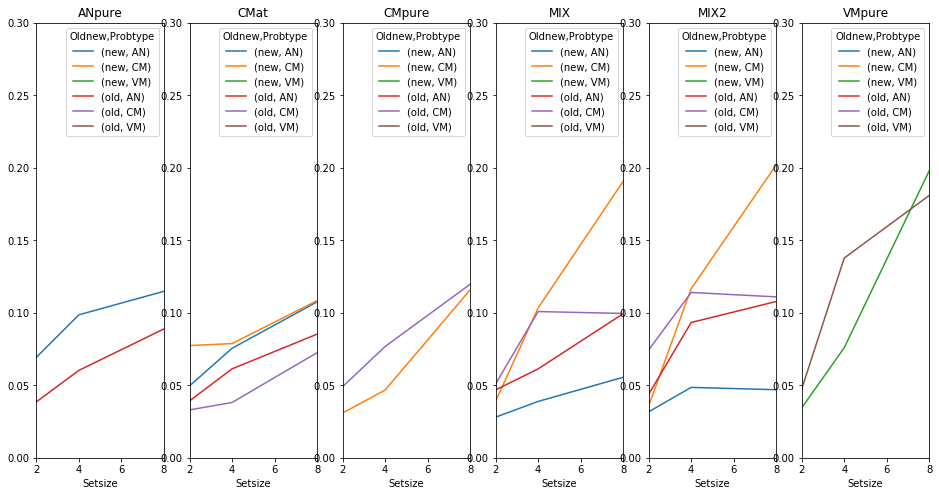

In [27]:
all_plot(df_all_aggnew, "Error",(0,0.3))

## correct RT plot

In [137]:
def all_plot(df_all_aggnew,plotwhaty,ylim):
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16,8))
    fig.canvas.set_window_title(plotwhaty)
    line_width = 2.5
    i=0
    names = df_all_aggnew["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    for iname in names:
        df_all_aggnew[df_all_aggnew["FileCondi"]==iname].plot.line(x="Setsize", y=plotwhaty,ax=axes[i],\
                                                                   title=iname,ylim=ylim )
        i+=1

# all_plot(df_all_aggnew, "RT",(600,1100))
# all_plot(df_all_aggnew, "pred_rt",(600,1100))
# all_plot(df_all_aggnew, "Error",(0,0.3))
# all_plot(df_all_aggnew, "pred_error",(0,1))

df_all_agg = df_all_crt.groupby(["Oldnew","Setsize","Probtype","FileCondi"]).agg(["mean"])#.apply(lambda x: x)
df_all_aggnew = df_all_agg.unstack(["Oldnew","Probtype"])
# df_all_aggnew = df_all_agg.unstack(["FileCondi","Oldnew","Probtype"])
df_all_aggnew
# df_all_aggnew= df_all_aggnew.swaplevel(i=0,j=2,axis = 1)

df_all_aggnew.index.name = 'Setsize'
df_all_aggnew.reset_index(inplace=True)


df_all_aggnew.columns = df_all_aggnew.columns.droplevel([1,2])
# df_all_aggnew

all_plot(df_all_aggnew, "RT",(600,1100))
all_plot(df_all_aggnew, "pred_rt",(600,1100))

NameError: name 'df_all_crt' is not defined